Here we will start developing the 2D variational autoencoder model for kuyf. now that we have seen taht its possible to generate gaussian like data with variational autoencoders we will try to do so in 3D

Firstly lets start by genarating some of our data, since the data is in 2D this should be a tad easier to generate and manipulate than 1D data

First import the necessary modules.

In [1]:
import tensorflow as tf 
from tensorflow import keras
import matplotlib.pyplot as plt 
import numpy as np
import sklearn
import pandas as pd

2022-02-04 14:13:21.981030: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Now we want to try to generate some 2D gaussian data with x and y being gaussian in nature 

In [ ]:
plt.plot(np.random.normal(0,1,100),np.random.normal(0,1,100),'.')



Now lets try to map this data into some other form that can be deroved from a gaussian , lets try as a test to map this data into a circular form of z/10 + z/|z|

We can use this method to generate whatever data we want but for now to showcase the capabilities of 2D data 

In [ ]:
x,y = np.random.normal(0,1,100),np.random.normal(0,1,100)


def g(xy):
    new_z = [] # define the transformed list
    for z in xy: # for 
        z = np.array(z) # for each x,y point in the distribution
        new_z.append(z / 10 + z / np.linalg.norm(z)) # transform it via this transformation and append new z
    return new_z

xy = zip(x, y)
res_z = g(xy)

print(res_z)
zx, zy = zip(*res_z)
plt.plot(zx,zy,'.')


we can define more transformations in order to benchmark the neural net that we are going to build.

Now with this can we reverse back into a gaussian Im going to try to figure this out and see if its possible but first im going to try to build a model for the gaussian data. For tommorow try to build the model for 2D data and evaluate if it generates gaussians, make some notes on the maths for the VAE to understand it better Build another model for the ring data.

The model here will need to take 2 features in the encoder

With previous kuyf model we had a tensor of whatever amount of normal numbers and we had about 50 distributions so we had a list of (50,n) where n is the number of data points in each distribution.

**how do we deploy this for the 2D case ?**


Lets start by generating some samples of 2D Gaussian data


In [ ]:
features_num = 100
coding_size=100

dataset = [(np.random.normal(0,1,100),np.random.normal(0,1,100)) for i in range (10)]
plt.plot(dataset[0][0],dataset[0][1],'.')
np.shape(dataset[0])

dataset = tf.constant(dataset,dtype=np.float32) 
np.shape(dataset[0])

In [ ]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


class Sampling(keras.layers.Layer):
    """
    samples codings from a normal distribution.samples a random vector from a normal 
    distribution with mean 0 and standard deviation of 1 
    """
    def call(self, inputs):
        mean, log_var = inputs
        return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2) + mean


        # Encoder part

inputs = keras.layers.Input(shape=[2,features_num])#2D data"
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(100, activation='selu')(z)
z = keras.layers.Dense(50, activation='selu')(z)
codings_mean = keras.layers.Dense(coding_size)(z)
codings_log_var = keras.layers.Dense(coding_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
encoder = keras.Model(inputs=inputs, outputs=[
                              codings_mean, codings_log_var, codings])

        # Decoder part

decoder_inputs = keras.layers.Input(shape=[coding_size])
x = keras.layers.Dense(50, activation='selu')(decoder_inputs)
x = keras.layers.Dense(100, activation='selu')(x)
x = keras.layers.Dense(2*features_num,activation=tf.keras.layers.LeakyReLU())(x)
outputs = keras.layers.Reshape([2,features_num])(x)
decoder = keras.Model(inputs=decoder_inputs, outputs=outputs)
# try add another layer with a sigmoid function activation or a simple 
# activation where we can learn to do the offset of the mean

        # Combine Encoder and Decoder

_, _, codings = encoder(inputs)
reconstructions = decoder(codings)
kuyf = keras.Model(inputs=inputs, outputs=reconstructions)

latent_loss = -0.5 * tf.reduce_sum(1 + codings_log_var - tf.exp(
            codings_log_var) - tf.square(codings_mean))
kuyf.add_loss(latent_loss)
kuyf.compile(loss=tf.keras.losses.KLDivergence(),
                          optimizer=keras.optimizers.Adam())

 Ok now that changes have been made to the kuyf variational autoencoder lets try to test it to see if it works.


In [ ]:
history = kuyf.fit(dataset,dataset,epochs=300 ,batch_size=32)
pd.DataFrame(history.history).plot()

 seems to run smooth without any major breaking errors, lets see what it generated when codings from a normal distribution are put into the decoder

In [ ]:
codings = tf.random.normal(shape=[1,coding_size])
new_gaussian_data = decoder(codings)
new_gaussian_data = tf.squeeze(new_gaussian_data)
new_gaussian_data
plt.plot(new_gaussian_data[0],new_gaussian_data[1],'.')

Wow, a result that looks like a gaussian is produced, and the editing of the forst kuyf function  to make the 2D kuyf was minimal, just change the shape of the inputs and add a flatten layer and a reshape layer at the end, we can see that the points are offset by about 2 units, we saw in the 1D case that this was the case aswell so this VAE actually offsets the two distributions by 2, the reason for this is unclear however i am planning to read more on the maths of the VAE in order to understand this so that this could be fixed in the future, this however can easily be fixed by just offsetting every point by -2. There are also some points outside the normal range of points, this is believed to be caused by the non - zero loss of the model.

The points also seem to be more bunched up, this is consistent with the 1D case, as we saw previously that the 1D case also had its distribtion bunched up 

**these insights are valuable** there is something we dont understand about the mathematics of the VAE, i presume that there is some connection between the generated codings from the sample layer and this effect.

Another likely cilprit is that the loss error may have been confused, I will examine the loss error to see if the maths is consistent with the KL divergence 

But for now we can see that the VAE does generate a gaussian shape, altough problems with 1D VAE are transported into the 2D VAE, its not suprising to consider that the 3D case will be the same.




Lets try to consider a different type of data for example ringed data in order to see if the VAE works with different distributions, There are several reasons why i want to do this:

1. VAE's incorporate gaussian distributions in their structure so are they biased to generate gaussian distribution better than other distributions

2. This experiment may give us clues into why the VAE acts the way it does (the offset of the points by 2 and the bunch up of data) 

In the past with 1D data we had some problems with mapping the data to different distributions, however this is easier in 2D data.

The gaussian data was of shape (10,2,100) lets try to generate some ringed data aswell



In [ ]:

x,y = np.random.normal(0,1,100),np.random.normal(0,1,100)


def g(xy):
    new_z = [] # define the transformed list
    for z in xy: # for 
        z = np.array(z) # for each x,y point in the distribution
        new_z.append(z / 10 + z / np.linalg.norm(z)) # transform it via this transformation and append new z
    return new_z

def circular(x,y):
    xy = zip(x, y)
    res_z = g(xy)
    zx, zy = zip(*res_z)
    plt.plot(zx,zy,'.')
    ring_data = tf.reshape([(zx,zy)],shape=[2,100])
    
    #print(ring_data)
    print(ring_data.shape)

ring_data = [circular(np.random.normal(0,1,100),np.random.normal(0,1,100)) for i in range(10)]



In [ ]:
dataset = [(np.random.normal(0,1,100),np.random.normal(0,1,100)) for i in range (10)]

dataset_new = []
for i in range(10):
    x,y = dataset[i][0],dataset[i][1]
    xy = zip(x,y)
    res_z = g(xy)
    zx, zy = zip(*res_z)
    zx,zy = tf.constant(zx),tf.constant(zy)
    data = tf.stack([zx,zy])
    dataset_new.append(data)
dataset_new = tf.squeeze(tf.stack([dataset_new]))
plt.plot(dataset_new[4][0],dataset_new[4][1],'.') # try to change widths so that everything is contained within a range for the activation function
    

In [ ]:
history = kuyf.fit(dataset_new,dataset_new,epochs=300 ,batch_size=32)

In [ ]:
codings = tf.random.normal(shape=[1,coding_size])
new_data = decoder(codings)
new_data = tf.squeeze(new_data)
plt.plot(new_data[0],new_data[1],'.')

There seems to be a big problem here but before we go onto the problem lets first see what we have done here

Firstly i have found a way to put the ringed data and potentially any transformed data into tensorial from so that it could be used by the model, any type of transformation that we can achieve can be put into tensorial form via this function, for 2D data atleast. I have trained the model made for the 2D data with the ringed data to see how well it works and found out that it doesnt work well at all.

There are several questionable properties of the model:
1. the model does not generate anything related to ringed data, my first tought behind this would be that we didnt introuduce non linearity in the activation functions of the model, so maybe if we introduced a non linear activation function for the output layer we can change the shape this takes
2. while the distribution generated does not look ringed at all , the loss is low, this means that we have coded something wrong with the loss function 

Firstly im going to try to make a new model and switch the activation function to something thats not linear, like a sigmoid 


In [ ]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


class Sampling(keras.layers.Layer):
    """
    samples codings from a normal distribution.samples a random vector from a normal 
    distribution with mean 0 and standard deviation of 1 
    """
    def call(self, inputs):
        mean, log_var = inputs
        return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2) + mean


        # Encoder part

inputs = keras.layers.Input(shape=[2,features_num])#2D data"
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(100, activation='sigmoid')(z)
z = keras.layers.Dense(50, activation='sigmoid')(z)
codings_mean = keras.layers.Dense(coding_size)(z)
codings_log_var = keras.layers.Dense(coding_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
encoder = keras.Model(inputs=inputs, outputs=[codings_mean, codings_log_var, codings])

        # Decoder part

decoder_inputs = keras.layers.Input(shape=[coding_size])
x = keras.layers.Dense(50, activation='sigmoid')(decoder_inputs)
x = keras.layers.Dense(100, activation='sigmoid')(x)
x = keras.layers.Dense(2*features_num,activation='sigmoid')(x)
outputs = keras.layers.Reshape([2,features_num])(x)
decoder = keras.Model(inputs=decoder_inputs, outputs=outputs)

# try add another layer with a sigmoid function activation or a simple 
# activation where we can learn to do the offset of the mean

# Combine Encoder and Decoder

_, _, codings = encoder(inputs)
reconstructions = decoder(codings)
kuyf_ring = keras.Model(inputs=inputs, outputs=reconstructions)

latent_loss = -0.5 * tf.reduce_sum(1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean))
kuyf_ring.add_loss(latent_loss)
kuyf_ring.compile(loss =tf.keras.losses.KLDivergence(), optimizer=keras.optimizers.Adam())
# see what happens for a hyperbolic tan activation functions
#try the radial basis function 

In [ ]:
history = kuyf_ring.fit(dataset_new,dataset_new,epochs=500 ,batch_size=32)

In [ ]:
codings = tf.random.normal(shape=[1,coding_size])
new_data = decoder(codings)
new_data = tf.squeeze(new_data)
plt.plot(new_data[0],new_data[1],'.')

Here i will describe some of the experimentation that was done with this problem,

1. Firstly i wanted to look at loss functions, for this i believe i made a mistake by including the KL divergence as the loss function, where it already is a part of the loss function so i will now research more loss functions 

 For now training kuyf for ringed data proves difficult so im going to try to find a way to do it in amore easier way. There are several aspects that need to be considered before continuing
 
 1. Train kuyf on ringed data to see how it acts 
 2. ringed data seems non reversible to gaussian data  so we need to find some mapping in order to compare generated data to gaussian
 3. Research mathematics and statistics of VAE's ( look at Carl Doersch paper) this will be difficult but understanding the mathematics is essential to proceeding to 3D 
 4. perform Chi squared test on the distributions to check if they are close to gaussians if they are not try to improve the model
 5. research into the loss functions of the VAE , try to find something that works better (might contact Seth)
 
 It is 12:45 am 2 Dec so im going to stop developing this for now since i do not want to code sloppy code 
 
 talk to string theory people to talk about mappings of data 
 try to make helper functions

 ## Seeing whats wrong
 
 in order to see the bigger picture we will perform a chi squared goodness of fit test on the 1D data for both the y axis and the x axis,we will see if the data corresponds to a gaussian. We will do this in the following way:
 1. firstly visualise both datasets and determine the mean and standard deviation of the dataset
          1.generate a gaussian and use VAE to copy the gaussian
 2. We will generate gaussian data using the determined standard deviation and mean 
 3. we will do a chisquared goodniess of fit test with the generated data and the VAE generated data 
 4. we will compare the results and comment on them
 

In [2]:
features_num = 1000
coding_size=10

dataset = [(np.random.normal(0,1,1000),np.random.normal(0,1,1000)) for i in range (10)] # creates gaussian data with 
# 100 data points for both x and y axis

plt.figure()
plt.title('')
plt.plot(dataset[0][0],dataset[0][1],'.')

plt.figure()
plt.title('Gaussian X-axis Generated Data')
plt.hist(dataset[0][0],bins=30)

plt.figure()
plt.title('Gaussian Y-axis Generated Data')
plt.hist(dataset[0][1],bins=30)

NameError: name 'np' is not defined

In [76]:
#lets feed the toy data into the VAE and see what it generates 

import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


class Sampling(keras.layers.Layer):
    """
    samples codings from a normal distribution.samples a random vector from a normal 
    distribution with mean 0 and standard deviation of 1 
    """
    def call(self, inputs):
        mean, log_var = inputs
        return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2) + mean


        # Encoder part

inputs = keras.layers.Input(shape=[2,features_num])#2D data"
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(100, activation='selu')(z)
z = keras.layers.Dense(50, activation='selu')(z)
codings_mean = keras.layers.Dense(coding_size)(z)
codings_log_var = keras.layers.Dense(coding_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
encoder = keras.Model(inputs=inputs, outputs=[
                              codings_mean, codings_log_var, codings])

        # Decoder part

decoder_inputs = keras.layers.Input(shape=[coding_size])
x = keras.layers.Dense(50, activation='selu')(decoder_inputs)
x = keras.layers.Dense(100, activation='selu')(x)
x = keras.layers.Dense(2*features_num,activation=tf.keras.layers.LeakyReLU())(x)
outputs = keras.layers.Reshape([2,features_num])(x)
decoder = keras.Model(inputs=decoder_inputs, outputs=outputs)
# try add another layer with a sigmoid function activation or a simple 
# activation where we can learn to do the offset of the mean

        # Combine Encoder and Decoder

_, _, codings = encoder(inputs)
reconstructions = decoder(codings)
kuyf = keras.Model(inputs=inputs, outputs=reconstructions)

latent_loss = -0.5 * tf.reduce_sum(1 + codings_log_var - tf.exp(
            codings_log_var) - tf.square(codings_mean))
kuyf.add_loss(latent_loss)
kuyf.compile(loss=tf.keras.losses.KLDivergence(),
                          optimizer=keras.optimizers.Adam())


#dataset_transformed = tf.constant(dataset,dtype=np.float32) 
#history = kuyf.fit(dataset_transformed,dataset_transformed,epochs=300 ,batch_size=32)
#pd.DataFrame(history.history).plot()

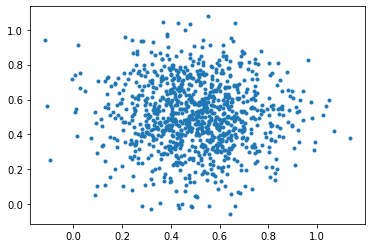

In [68]:
#generate new 'gaussian' data

codings = tf.random.normal(shape=[1,coding_size])
new_gaussian_data = decoder(codings)
new_gaussian_data = tf.squeeze(new_gaussian_data)

plt.plot(new_gaussian_data[0],new_gaussian_data[1],'.')

In [63]:
# we see the distribution for both the x and y axis and they are pretty similar, its good to see that the model
# doesnt discriminate between x and y values i mean why should it?

(array([[  3.,   3.,   7.,  14.,  24.,  44.,  65.,  89., 151., 110., 143.,
         125.,  87.,  57.,  30.,  22.,  16.,   5.,   4.,   1.],
        [  1.,  10.,   7.,  20.,  27.,  41.,  63.,  99., 119., 133., 122.,
         106.,  80.,  72.,  47.,  30.,  13.,   5.,   4.,   1.]]),
 array([-0.11413275, -0.05177122,  0.01059032,  0.07295185,  0.13531338,
         0.19767492,  0.26003644,  0.32239798,  0.38475952,  0.44712102,
         0.50948256,  0.5718441 ,  0.63420564,  0.6965672 ,  0.7589287 ,
         0.82129025,  0.88365173,  0.9460133 ,  1.0083748 ,  1.0707364 ,
         1.1330979 ], dtype=float32),
 <a list of 2 BarContainer objects>)

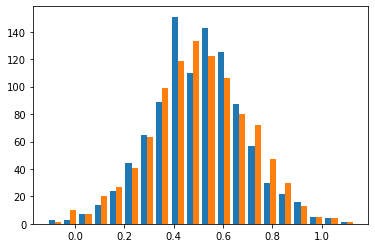

In [69]:
# now that we have seen the data, lets determine the standard deviation and the mean from them and generate a 
# 'perfect' gaussian
plt.hist(new_gaussian_data,bins=20)

In [33]:
def stats_dist(dist, dist2=None, prnt=True):
    """
    Calculates the mean, standard deviation, variance, and covariance matrix of a distribution. The function also includes
    the option to calculate the covariance matrix of two distributions. To do this, pass the second distribution as the
    second parameter.
    Parameters:
        - dist (numpy array): The distribution to be analyzed.
        - dist2 (numpy array): The second distribution to be analyzed.
        - prnt (bool): Whether or not to print the results. If print is False, the function will simply return the
        results.
    """
    if prnt:
        print("-------------------------------")
        print("Mean:", np.mean(dist))
        print("-------------------------------")
        print("Standard deviation:", np.std(dist))
        print("-------------------------------")
        print("Variance:", np.var(dist))
        print("-------------------------------")
        if dist2 is not None:
            print("Covariance matrix:", np.cov(dist, dist2))
            return np.mean(dist), np.std(dist), np.var(dist), np.cov(dist, dist2)
        else:
            print("Covariance:", np.cov(dist))  # Will be a scalar

    return np.mean(dist), np.std(dist), np.var(dist), np.cov(dist)


def df_style(_):
    return "font-weight: bold"


def df_generator(stats_or_x, stats_gen_x, stats_or_y, stats_gen_y, rows: np.ndarray, df_style):
    """
    Generates a dataframe with the given parameters.
    Parameters:
        - stats_or_x: The stats of the x-dimension from the train data.
        - stats_gen_x: The stats of the x-dimension from the generated data.
        - stats_or_y: The stats of the y-dimension from the train data.
        - stats_gen_y: The stats of the y-dimension from the generated data.
        - rows: Numpy array with the rows of the dataframe as strings.
        - df_style: The style of the dataframe. Should be coming from a function like "df_style"
    """
    stats_df = pd.DataFrame()
    stats_df[" "] = rows
    stats_df["original_x_dim"] = np.array([stats_or_x[0], stats_or_x[1], stats_or_x[2], stats_or_x[3].item()])
    stats_df["generated_x_dim"] = np.array([stats_gen_x[0], stats_gen_x[1], stats_gen_x[2], stats_gen_x[3].item()])
    stats_df["original_y_dim"] = np.array([stats_or_y[0], stats_or_y[1], stats_or_y[2], stats_or_y[3].item()])
    stats_df["generated_y_dim"] = np.array([stats_gen_y[0], stats_gen_y[1], stats_gen_y[2], stats_gen_y[3].item()])
    stats_df = stats_df.style.applymap(df_style, subset=[" "])

    return stats_df

In [70]:
meanx, sdx, varx, covx = stats_dist(new_gaussian_data[0],dataset[0][0],prnt=True) # comparing the x axis values

-------------------------------
Mean: 0.50121534
-------------------------------
Standard deviation: 0.18690772
-------------------------------
Variance: 0.034934495
-------------------------------
Covariance matrix: [[ 0.03496946 -0.00645954]
 [-0.00645954  0.95826695]]


In [71]:
meany, sdy, vary, covy = stats_dist(new_gaussian_data[1],dataset[0][1],prnt=True) # comparing the y values

-------------------------------
Mean: 0.5029266
-------------------------------
Standard deviation: 0.1974368
-------------------------------
Variance: 0.038981285
-------------------------------
Covariance matrix: [[ 0.0390203  -0.0085158 ]
 [-0.0085158   0.98016044]]


In [72]:
testing_gaussian_y = np.random.normal(meany,sdy,1000)
testing_gaussian_x = np.random.normal(meanx,sdx,1000)

(array([ 1.,  0.,  3.,  0.,  5., 10., 10., 21., 42., 35., 35., 60., 63.,
        79., 72., 74., 87., 76., 62., 66., 50., 40., 28., 29., 22., 10.,
        10.,  6.,  2.,  2.]),
 array([-3.21722192, -3.01500963, -2.81279733, -2.61058504, -2.40837275,
        -2.20616046, -2.00394817, -1.80173587, -1.59952358, -1.39731129,
        -1.195099  , -0.9928867 , -0.79067441, -0.58846212, -0.38624983,
        -0.18403753,  0.01817476,  0.22038705,  0.42259934,  0.62481163,
         0.82702393,  1.02923622,  1.23144851,  1.4336608 ,  1.6358731 ,
         1.83808539,  2.04029768,  2.24250997,  2.44472227,  2.64693456,
         2.84914685]),
 <BarContainer object of 30 artists>)

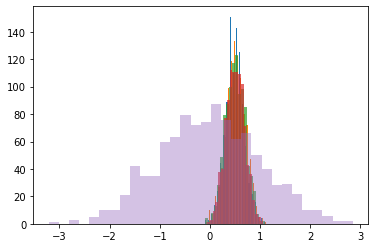

In [73]:
new_gaussian_bins = plt.hist(new_gaussian_data,bins=20)
testing_gaussian_y_bins = plt.hist(testing_gaussian_y,bins=20,alpha=0.7)
testing_gaussian_x_bins = plt.hist(testing_gaussian_x,bins=20,alpha=0.7)
plt.hist(dataset[0][1],bins=30,alpha =0.4)

In [46]:
import cv2 as cv

cv.compareHist(new_gaussian_data[0].numpy(), testing_gaussian_y.astype('float32'),cv.HISTCMP_CHISQR) # try redoing with 1000
# increase to 1000 datapoints and see if chi squared improves if it doesnt examine your model.

267.9403073999805

In [45]:
# chi squred is negative which is not expected, maybe this is due to hte fact that the distributions have
# negative values so lets see if shifting the distribution by a set amount of number will imporve the score 
cv.compareHist((new_gaussian_data[0]+10).numpy(), (testing_gaussian_y+10).astype('float32'),cv.HISTCMP_CHISQR)


15.057229205032066

In [74]:
# seems to improve and not be negative when i add a constant to the distributions, but the problem is that 
# even after adding a large number to these the chisqured should technically stay the same if it doesnt why even use 
# it as a metric there is something here that is wrong? 

import scipy
scipy.stats.chisquare(new_gaussian_bins[0][0],testing_gaussian_x_bins[0],axis=None)

#new_gaussian_bins[0][0],testing_gaussian_x_bins[0]

Power_divergenceResult(statistic=52.96817022947711, pvalue=4.7329549828257075e-05)

Epoch 1/300
1/1 [==============================] - 0s 356ms/step - loss: 29529.7539
Epoch 2/300
1/1 [==============================] - 0s 32ms/step - loss: 220959653888.0000
Epoch 3/300
1/1 [==============================] - 0s 40ms/step - loss: 11625713.0000
Epoch 4/300
1/1 [==============================] - 0s 43ms/step - loss: 98003402752.0000
Epoch 5/300
1/1 [==============================] - 0s 43ms/step - loss: 188710224.0000
Epoch 6/300
1/1 [==============================] - 0s 42ms/step - loss: 182408720.0000
Epoch 7/300
1/1 [==============================] - 0s 46ms/step - loss: 74918640.0000
Epoch 8/300
1/1 [==============================] - 0s 62ms/step - loss: 34847640.0000
Epoch 9/300
1/1 [==============================] - 0s 47ms/step - loss: 16655747.0000
Epoch 10/300
1/1 [==============================] - 0s 47ms/step - loss: 17489778.0000
Epoch 11/300
1/1 [==============================] - 0s 47ms/step - loss: 48851440.0000
Epoch 12/300
1/1 [===========================

1/1 [==============================] - 0s 46ms/step - loss: 21821.9844
Epoch 194/300
1/1 [==============================] - 0s 49ms/step - loss: 21523.5879
Epoch 195/300
1/1 [==============================] - 0s 43ms/step - loss: 21414.3613
Epoch 196/300
1/1 [==============================] - 0s 34ms/step - loss: 21331.6816
Epoch 197/300
1/1 [==============================] - 0s 35ms/step - loss: 21201.5137
Epoch 198/300
1/1 [==============================] - 0s 30ms/step - loss: 21129.4668
Epoch 199/300
1/1 [==============================] - 0s 33ms/step - loss: 20974.9492
Epoch 200/300
1/1 [==============================] - 0s 38ms/step - loss: 20912.2461
Epoch 201/300
1/1 [==============================] - 0s 30ms/step - loss: 20798.6270
Epoch 202/300
1/1 [==============================] - 0s 34ms/step - loss: 20692.2344
Epoch 203/300
1/1 [==============================] - 0s 35ms/step - loss: 20592.3398
Epoch 204/300
1/1 [==============================] - 0s 33ms/step - loss: 20534

<AxesSubplot:>

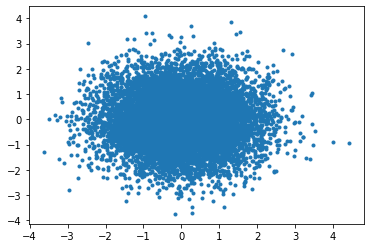

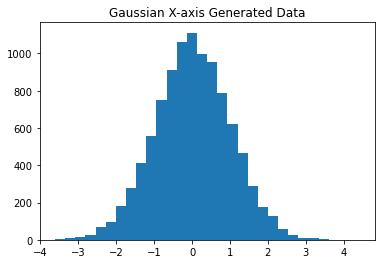

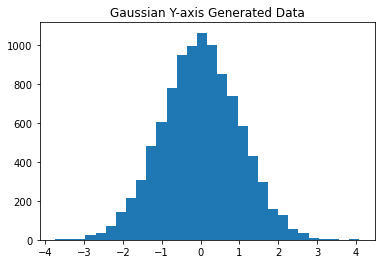

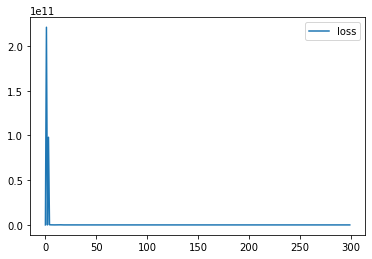

In [77]:
# increasing the number of elements to see if the statistic changes  from 1000 to 100000

features_num = 10000
coding_size=10

dataset = [(np.random.normal(0,1,features_num),np.random.normal(0,1,features_num)) for i in range (10)] # creates gaussian data with 
# 100 data points for both x and y axis

plt.figure()
plt.title('')
plt.plot(dataset[0][0],dataset[0][1],'.')

plt.figure()
plt.title('Gaussian X-axis Generated Data')
plt.hist(dataset[0][0],bins=30)

plt.figure()
plt.title('Gaussian Y-axis Generated Data')
plt.hist(dataset[0][1],bins=30)


dataset_transformed = tf.constant(dataset,dtype=np.float32) 
history = kuyf.fit(dataset_transformed,dataset_transformed,epochs=300 ,batch_size=32)
pd.DataFrame(history.history).plot()

Epoch 1/100
1/1 [==============================] - 0s 33ms/step - loss: 103.7323
Epoch 2/100
1/1 [==============================] - 0s 40ms/step - loss: 103.3607
Epoch 3/100
1/1 [==============================] - 0s 33ms/step - loss: 103.0283
Epoch 4/100
1/1 [==============================] - 0s 44ms/step - loss: 102.7124
Epoch 5/100
1/1 [==============================] - 0s 44ms/step - loss: 102.3163
Epoch 6/100
1/1 [==============================] - 0s 44ms/step - loss: 101.9821
Epoch 7/100
1/1 [==============================] - 0s 46ms/step - loss: 101.6689
Epoch 8/100
1/1 [==============================] - 0s 58ms/step - loss: 101.3988
Epoch 9/100
1/1 [==============================] - 0s 49ms/step - loss: 100.9707
Epoch 10/100
1/1 [==============================] - 0s 38ms/step - loss: 100.6520
Epoch 11/100
1/1 [==============================] - 0s 39ms/step - loss: 100.3332
Epoch 12/100
1/1 [==============================] - 0s 40ms/step - loss: 100.0038
Epoch 13/100
1/1 [=======

<AxesSubplot:>

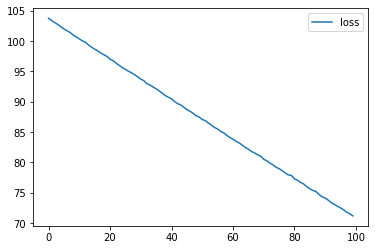

In [86]:
dataset_transformed = tf.constant(dataset,dtype=np.float32) 
history = kuyf.fit(dataset_transformed,dataset_transformed,epochs=100 ,batch_size=32)
pd.DataFrame(history.history).plot()

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,
          1.,   0.,   2.,   1.,   2.,   1.,   4.,   5.,   6.,   8.,  13.,
         25.,  22.,  39.,  33.,  44.,  68.,  85.,  79., 101., 109., 133.,
        167., 157., 208., 209., 231., 261., 279., 288., 292., 293., 345.,
        375., 360., 372., 399., 384., 400., 371., 375., 371., 365., 344.,
        286., 274., 264., 233., 202., 175., 141., 153., 128.,  99.,  80.,
         61.,  50.,  55.,  38.,  41.,  25.,  15.,  10.,  13.,   8.,   4.,
          6.,   1.,   2.,   3.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([0.32991555, 0.34966946, 0.3694234 , 0.3891773 , 0.4089312 ,
        0.4286851 , 0.44843903, 0.46819293, 0.48794684, 0.50770074,
        0.5274547 , 0.54720855, 0.5669625 , 0.5867164 , 0.6064703 ,
        0.6262242 , 0.64597815, 0.665732  , 0.68548596, 0.7052399 ,
        0.72499377, 0.7447477 , 0.7645016 , 0.

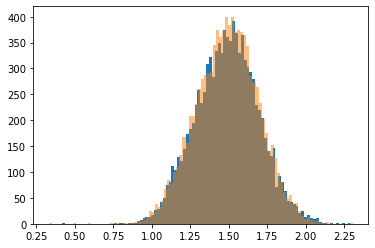

In [121]:
codings = tf.random.normal(shape=[1,coding_size])
new_gaussian_data = decoder(codings)
new_gaussian_data = tf.squeeze(new_gaussian_data)

plt.hist(np.array(new_gaussian_data)[0],bins=100) # x data
plt.hist(np.array(new_gaussian_data)[1],bins=100,alpha=0.5) # y data

In [93]:
meanx, sdx, varx, covx = stats_dist(new_gaussian_data[0],dataset[0][0],prnt=True) # comparing the x axis values
meany, sdy, vary, covy = stats_dist(new_gaussian_data[1],dataset[0][1],prnt=True) # comparing the y values
testing_gaussian_y = np.random.normal(meany,sdy,10000)
testing_gaussian_x = np.random.normal(meanx,sdx,10000)

-------------------------------
Mean: 1.516406
-------------------------------
Standard deviation: 0.20612189
-------------------------------
Variance: 0.04248623
-------------------------------
Covariance matrix: [[ 0.04249048 -0.01385058]
 [-0.01385058  0.99184429]]
-------------------------------
Mean: 1.5133486
-------------------------------
Standard deviation: 0.19898887
-------------------------------
Variance: 0.03959657
-------------------------------
Covariance matrix: [[ 0.03960053 -0.01257382]
 [-0.01257382  1.00090327]]


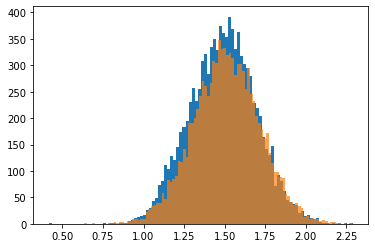

In [140]:
new_gaussian_bins = plt.hist(np.array(new_gaussian_data)[0],bins=100) # histogram of x data
testing_gaussian_x_bins = plt.hist(testing_gaussian_x,bins=100,alpha=0.7)
#plt.hist(dataset[0][1],bins=100,alpha=0.5)

In [141]:
print((new_gaussian_bins[0]))
print((new_gaussian_bins[0]))
scipy.stats.chisquare(new_gaussian_bins[0],testing_gaussian_x_bins[0],axis=None)

[  1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   1.   0.   1.   1.   0.   1.   2.   2.   5.   7.
  11.  13.  14.  17.  26.  29.  43.  49.  74.  81. 111. 103. 129. 121.
 145. 173. 184. 194. 230. 258. 233. 255. 308. 322. 283. 334. 350. 329.
 374. 361. 354. 392. 368. 330. 364. 317. 302. 294. 280. 229. 219. 204.
 165. 141. 130. 147.  71.  92.  81.  63.  45.  42.  38.  35.  20.  25.
  14.  17.  11.  10.  11.   3.   2.   2.   0.   2.   0.   2.   0.   1.
   0.   2.]
[  1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   1.   0.   1.   1.   0.   1.   2.   2.   5.   7.
  11.  13.  14.  17.  26.  29.  43.  49.  74.  81. 111. 103. 129. 121.
 145. 173. 184. 194. 230. 258. 233. 255. 308. 322. 283. 334. 350. 329.
 374. 361. 354. 392. 368. 330. 364. 317. 302. 294. 280. 229. 219. 204.
 165. 141. 130. 147.  71.  92.  81.  63.  45.  42.  38.  35.  20.  25.
  14.  17.  11.  10.  11.   3.   2.   2.   0.   2.   0.   2.   0.

Power_divergenceResult(statistic=nan, pvalue=nan)

In [143]:
#we may need to construct our own chi squared algorithm in order to have reloiable results 
# the problem with this is that we have bins of 0 frequency and that will mess up the cacluations lets see
# if we can find another way of constructing the bins 

# use numpy histograms

np.histogram(np.array(new_gaussian_data)[0],bins=100)
# even with the numy histograms we get the zero bins so how do we solve this problem ???

(array([  1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   1,   0,   1,   1,   0,   1,   2,   2,
          5,   7,  11,  13,  14,  17,  26,  29,  43,  49,  74,  81, 111,
        103, 129, 121, 145, 173, 184, 194, 230, 258, 233, 255, 308, 322,
        283, 334, 350, 329, 374, 361, 354, 392, 368, 330, 364, 317, 302,
        294, 280, 229, 219, 204, 165, 141, 130, 147,  71,  92,  81,  63,
         45,  42,  38,  35,  20,  25,  14,  17,  11,  10,  11,   3,   2,
          2,   0,   2,   0,   2,   0,   1,   0,   2]),
 array([0.41500264, 0.43374854, 0.45249447, 0.47124037, 0.48998627,
        0.5087322 , 0.5274781 , 0.546224  , 0.5649699 , 0.5837158 ,
        0.6024617 , 0.62120765, 0.63995355, 0.65869945, 0.67744535,
        0.69619125, 0.71493715, 0.7336831 , 0.752429  , 0.7711749 ,
        0.7899208 , 0.8086667 , 0.8274126 , 0.8461585 , 0.86490446,
        0.88365036, 0.90239626, 0.92114216, 0.93988806, 0.95863396,
        0.9773799 , 0.9961